In [3]:
!pip install pygrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 45.4 MB/s eta 0:00:00


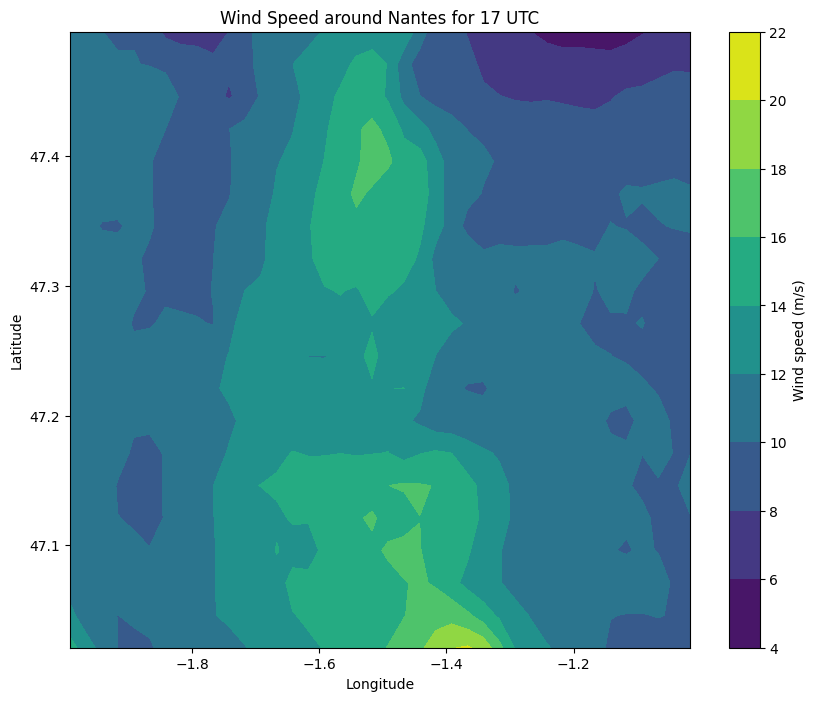

In [4]:
import pygrib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd


# Step 1: Load the GRIB file
grib_file = '/content/arome_10m_NW_20170112000000.grib'

# Define the bounding box by coordinates
lat_min = 47.0
lat_max = 47.5
lon_min = -2.0
lon_max = -1.0

# Step 2: Open the GRIB file
grbs = pygrib.open(grib_file)

valid_time_of_interest = 1700
valid_date_of_interest = 20170112

# Loop through the messages to find the one corresponding to 17 UTC
for grb in grbs:
    if grb.validityTime == valid_time_of_interest and grb.validityDate == valid_date_of_interest:
        data, lats, lons = grb.data(lat1=lat_min, lat2=lat_max, lon1=lon_min, lon2=lon_max)
        break

# Close the GRIB file
grbs.close()

# Step 4: Plot the data using matplotlib
plt.figure(figsize=(10, 8))
plt.contourf(lons, lats, data, cmap='viridis')
plt.colorbar(label='Wind speed (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Speed around Nantes for 17 UTC')
plt.show()

In [6]:
lat_lon_pairs = np.column_stack((lats.ravel(), lons.ravel()))
data_flat = data.ravel()
df = pd.DataFrame(lat_lon_pairs, columns=['Latitude', 'Longitude'])
df['Wind Speed'] = data_flat

In [7]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import branca


# Define the size of the grid cell
step = 0.025

# Aggregate data on a regular grid
df['lat_grid'] = np.floor(df['Latitude'] / step) * step
df['lon_grid'] = np.floor(df['Longitude'] / step) * step
grid_data = df.groupby(['lat_grid', 'lon_grid'])['Wind Speed'].mean().reset_index()

# Normalize the wind speed values for the custom color map
grid_data['normalized_value'] = np.where(grid_data['Wind Speed'] > 10, 1, 0)  # 1 for red, 0 for green

# Define a custom color map function
def custom_color_map(value):
    if value > 12:
        return '#FF0000'  # Red for values greater than 10
    else:
        return '#00FF00'  # Green for values less than or equal to 10

# Define a function to create GeoJSON for each grid cell
def geo_json(lat, lon, value, step):
    return {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {
                    'color': 'white',
                    'weight': 0.1,
                    'fillColor': custom_color_map(value),
                    'fillOpacity': 0.5,
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[
                        [lon, lat],
                        [lon, lat + step],
                        [lon + step, lat + step],
                        [lon + step, lat],
                        [lon, lat],
                    ]]
                }
            }
        ]
    }

# Create a Folium map centered around Nantes
lat0, lon0 = 47.2184, -1.5536
m = folium.Map(location=[lat0, lon0], zoom_start=11, width=800, height=600)

# Add grid cells to the map
for _, row in grid_data.iterrows():
    folium.GeoJson(geo_json(row['lat_grid'], row['lon_grid'], row['Wind Speed'], step),
                   lambda x: x['properties']).add_to(m)

# Add the original data points to the map
'''for _, row in df.iterrows():
    folium.Circle(location=[row['Latitude'], row['Longitude']],
                  color="white",
                  radius=row['Wind Speed'] * 0,  # Scale radius for better visibility
                  fill=True).add_to(m)'''

# Create the custom legend as HTML
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 90px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <b>Wind Speed (m/s)</b><br>
    <i style="background: #00FF00; width: 10px; height: 10px; display: inline-block;"></i> &lt; 10<br>
    <i style="background: #FF0000; width: 10px; height: 10px; display: inline-block;"></i> &gt; 10
</div>
'''

# Add custom legend to the map
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

# Display the map
m.save('nantes_wind_speed_map_with_custom_legend.html')
m

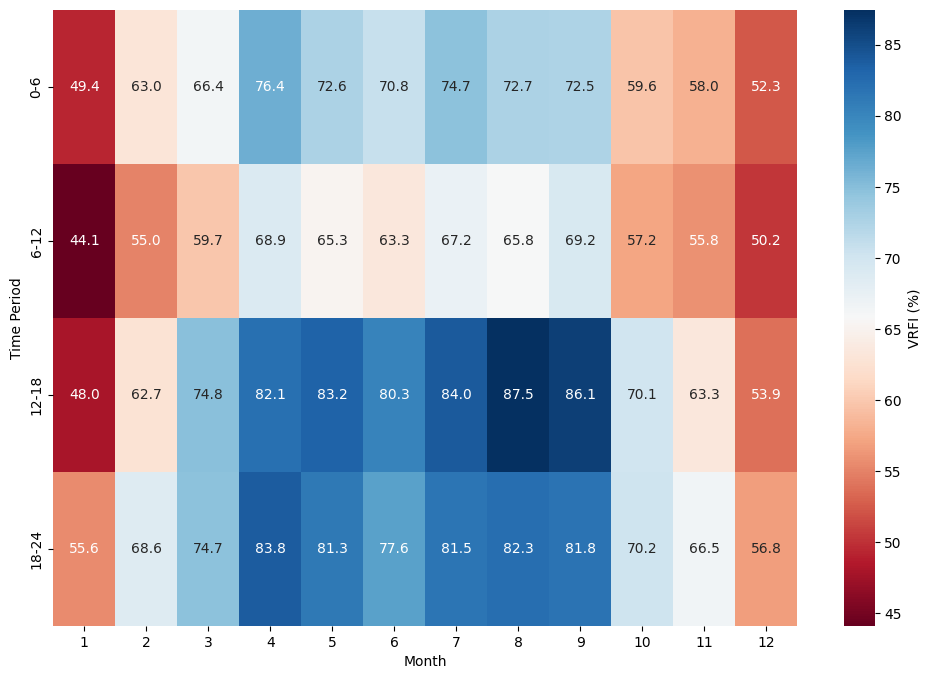